In [2]:
import pandas as pd
import pickle as pkl
import numpy as np
import emoji
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import pandas as pd
from tqdm import tqdm_notebook, tqdm
import multiprocessing as mp
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from scipy.ndimage import gaussian_filter1d
from scipy.stats import spearmanr, pearsonr
import os
import pickle as pkl
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import multiprocessing as mp
import io
import sys
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raileanu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raileanu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
cd /mlodata1/raileanu/Topics_Visualization/paper_code/scripts

/mlodata1/raileanu/Topics_Visualization/paper_code/scripts


In [4]:
topics = pkl.load(open('/mlodata1/prakhar/twitter_covid_insights/insights_All/topics.pkl', 'rb'))[0]

In [5]:
daily_occ_per_topic = pkl.load(open('/mlodata1/prakhar/twitter_covid_insights/insights_All/trends_raw.pkl', 'rb'))[0]

In [6]:
tot_occ_per_topic = {}
for topic in daily_occ_per_topic:
    if not topic.startswith('Pos-') and not topic.startswith('Neg-'):
        tot_occ_per_topic[topic] = np.sum(np.array(daily_occ_per_topic[topic]))
    
tot_occ_per_topic = dict(sorted(tot_occ_per_topic.items(), key=lambda item: -item[1]))
most_cited = [int(x) for x in list(tot_occ_per_topic.keys())[:10]]
print(f"Most cited topics: {most_cited}")

Most cited topics: [71, 39, 29, 141, 19, 80, 117, 60, 211, 75]


In [8]:
# Labeling the top 10 topics with the first hashtag and creating a dict with their occurrences
labels = {}
most_cited_daily_occ = {}
for topic in most_cited:
    labels[topic] = topics[topic][0]
    print(topics[topic])
    #most_cited_daily_occ[topic] = gaussian_filter1d(daily_occ_per_topic[str(topic)], 3)
    most_cited_daily_occ[topic] = daily_occ_per_topic[str(topic)]



['#vaccine' '#covidvaccine' '#vaccines' '#vaccinated' '#covid19vaccine'
 '#moderna' '#vaccinations' '#pfizervaccine' '#covidvaccines'
 '#pfizerbiontech' '#johnsonandjohnson' '#covid19vaccines'
 '#modernavaccine' '#astrazenecavaccine' '#boostershots'
 '#oxfordastrazeneca' '#vaccinehesitancy' '#pfizercovidvaccine'
 '#johnsonandjohnsonvaccine' '#boostershot' '#phizer']
['#china' '#wuhan' '#chinavirus' '#wuhanvirus' '#ccp' '#chinesevirus'
 '#wuhancoronavirus' '#ccpvirus' '#chinaliedpeopledied' '#chinese'
 '#ccpchina' '#xijinping' '#chinaliedandpeopledied' '#chinamustpay'
 '#wuhanflu' '#chinazi' '#ccpliedpeopledied' '#makechinapay' '#wuhanlab'
 '#kungflu' '#chinajoe' '#china_is_terrorist' '#beijingbiden'
 '#chinesecommunistparty' '#chinajoebiden' '#communistchina'
 '#bidencrimefamilly' '#xitler' '#bidencrimefamiily']
['#trump' '#biden' '#america' '#gop' '#donaldtrump' '#democrats'
 '#joebiden' '#americans' '#republicans' '#potus' '#scotus' '#american'
 '#republican' '#democrat' '#kentucky' 

In [131]:
# Re labeling for better visualization
new_labels = {71: 'COVID-19 Vaccines', 39: 'COVID-19 China', 29: 'American elections', 
              141: 'Tokyo Olympics', 19: 'COVID-19 Outbreak', 80: 'Stay safe', 117: 'Daily motivation',
              60: 'Pro vax', 211: 'World news', 75: 'Work from home'}

In [132]:
# Adding zeroes to the dates that are missing

missing_dates = ['2020-08-06',
'2020-08-07',
'2020-08-08',
'2020-08-09',
'2020-08-10',
'2020-08-11',
'2020-08-12',
'2020-08-13',
'2020-08-14',
'2020-08-15',
'2020-08-16',
'2020-08-17',
'2020-08-18',
'2020-08-19',
'2020-08-20',
'2020-08-21',
'2020-08-22',
'2020-08-23',
'2020-08-24',
'2020-08-25',
'2020-08-26',
'2020-08-27',
'2020-08-28',
'2020-08-29',
'2020-08-30',
'2020-08-31',
'2020-09-01',
'2020-09-02',
'2020-09-03',
'2020-09-04',
'2021-04-18',
'2021-04-19',
'2021-04-24',
'2021-04-25',
'2021-05-18',
'2021-05-19',
'2021-05-20',
'2021-05-21',
'2021-05-22',
'2021-05-23',
'2021-05-24',
'2021-05-25',
'2021-07-22',
'2021-07-23',
'2021-07-24',
'2021-07-25']

# Appending nan values for the dates that are missing
for topic in most_cited_daily_occ:
    new_values = []
    index = 0
    for i, d in enumerate(pd.date_range('2019-10-01', '2021-09-30')):
        date = d.strftime('%Y-%m-%d')
        if date in missing_dates:
            new_values.append(np.nan)
        elif most_cited_daily_occ[topic][index] < 500:
            new_values.append(np.nan)
            index+=1
        else: 
            new_values.append(most_cited_daily_occ[topic][index])
            index += 1
    most_cited_daily_occ[topic] = new_values

In [133]:
# Linearly interpolating missing values and smoothing
for topic in most_cited_daily_occ:
    most_cited_daily_occ[topic] = pd.Series(most_cited_daily_occ[topic]).interpolate().tolist()
    most_cited_daily_occ[topic] = gaussian_filter1d(most_cited_daily_occ[topic], 2)

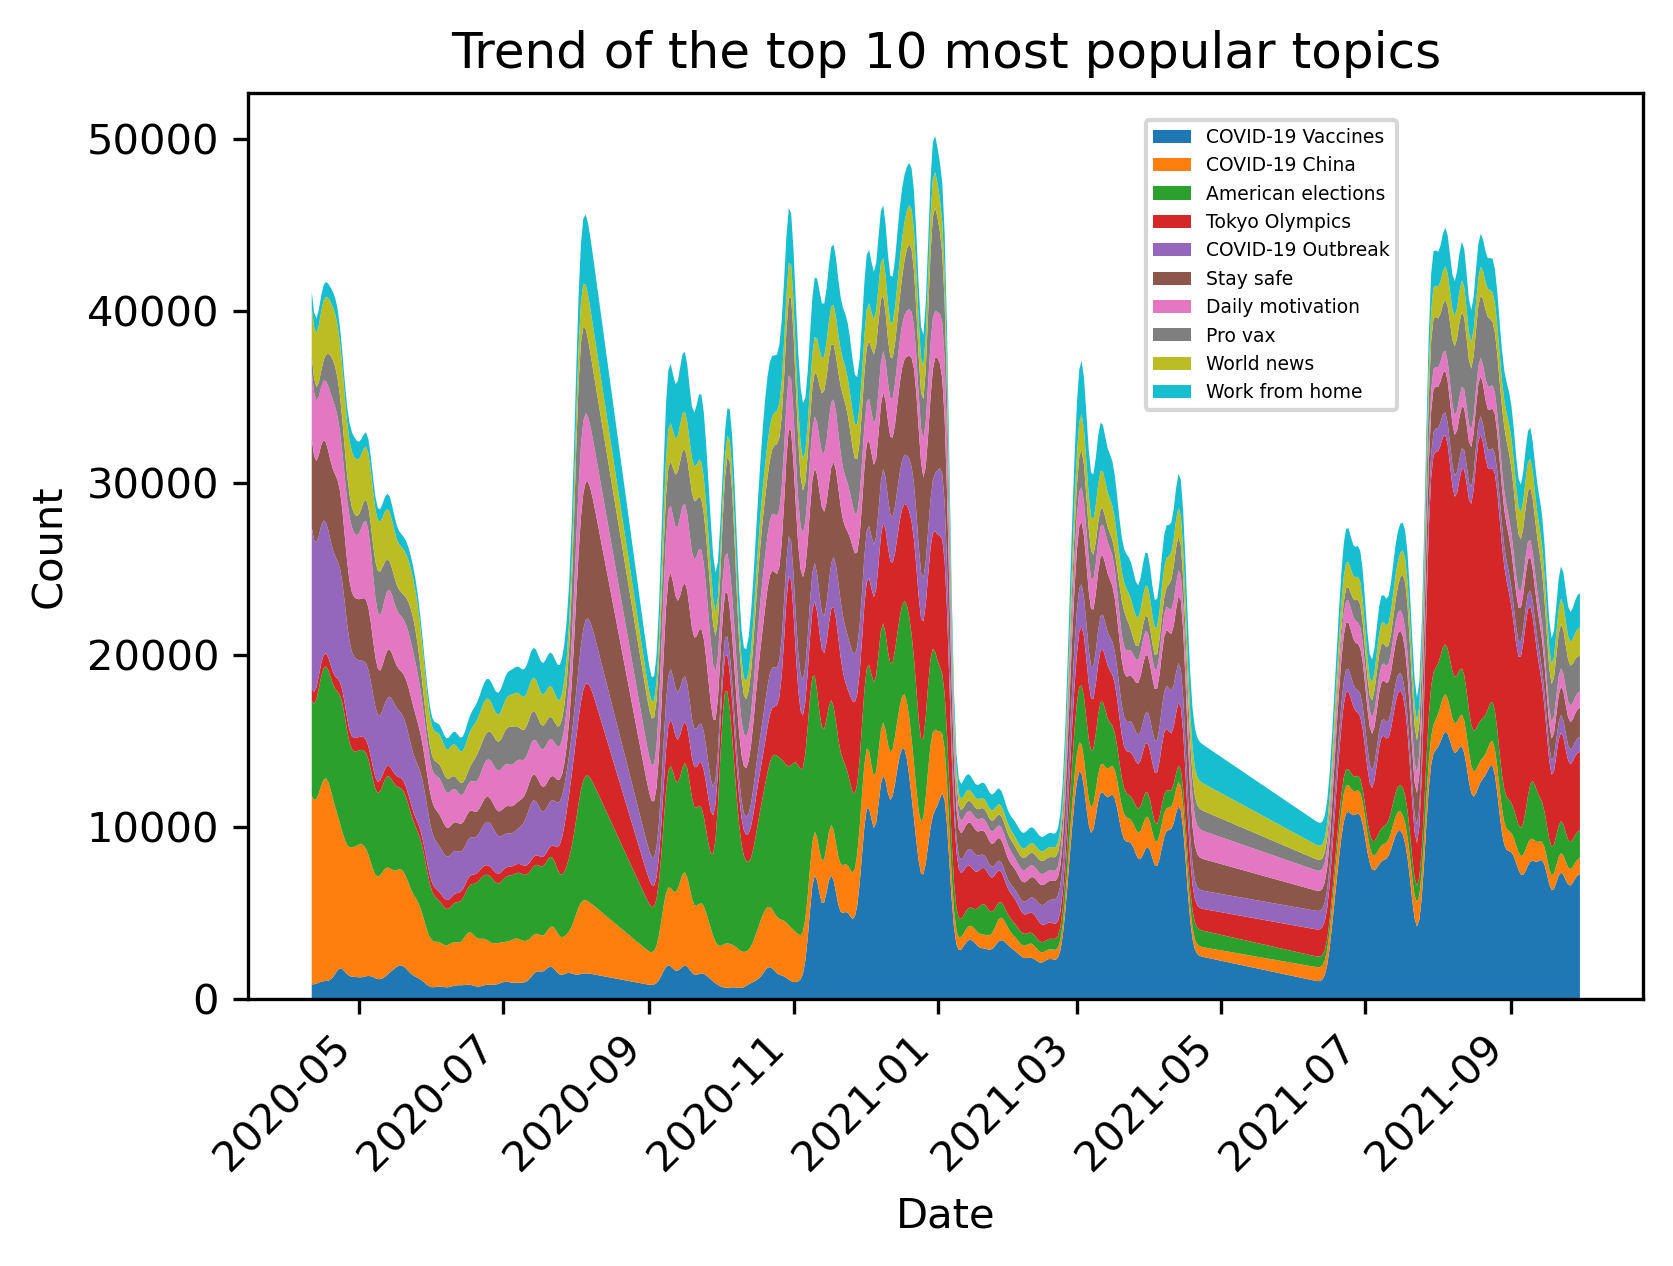

In [134]:
# Stack plot
plt.stackplot(pd.date_range('2019-10-01', '2021-09-30'), 
              most_cited_daily_occ[71], 
              most_cited_daily_occ[39], 
              most_cited_daily_occ[29],
              most_cited_daily_occ[141],
              most_cited_daily_occ[19],
              most_cited_daily_occ[80],
              most_cited_daily_occ[117],
              most_cited_daily_occ[60],
              most_cited_daily_occ[211],
              most_cited_daily_occ[75],
              labels=list(new_labels.values()))
plt.legend(fontsize = 4.5, bbox_to_anchor=(0.83, 0.98))
plt.xticks(rotation=45, ha="right")
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
plt.title('Trend of the top 10 most popular topics')
plt.ylabel('Count')
plt.xlabel('Date');

In [135]:
cd /mlodata1/raileanu/Topics_Visualization/paper_code/Data

/mlodata1/raileanu/Topics_Visualization/paper_code/Data


In [136]:
# checking if COVID trend in japan is correlated with Tokyo Olympics topic
epi_data = pd.read_csv('global_countries.csv')
japan_data = epi_data[epi_data['name'] == 'Japan']

/home/mannarin/.conda/envs/nlp_env_new/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (124,129,130,131,148,149,150,210,211,212,213,214,215,216,217,232,233,234,235,236,237,238,239,240,277,279,280,281) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [137]:
japan_data = japan_data[(japan_data['date'] >= '2020-04-01') & (japan_data['date'] <= '2021-09-30')]
olympics_trend = most_cited_daily_occ[141][184:]

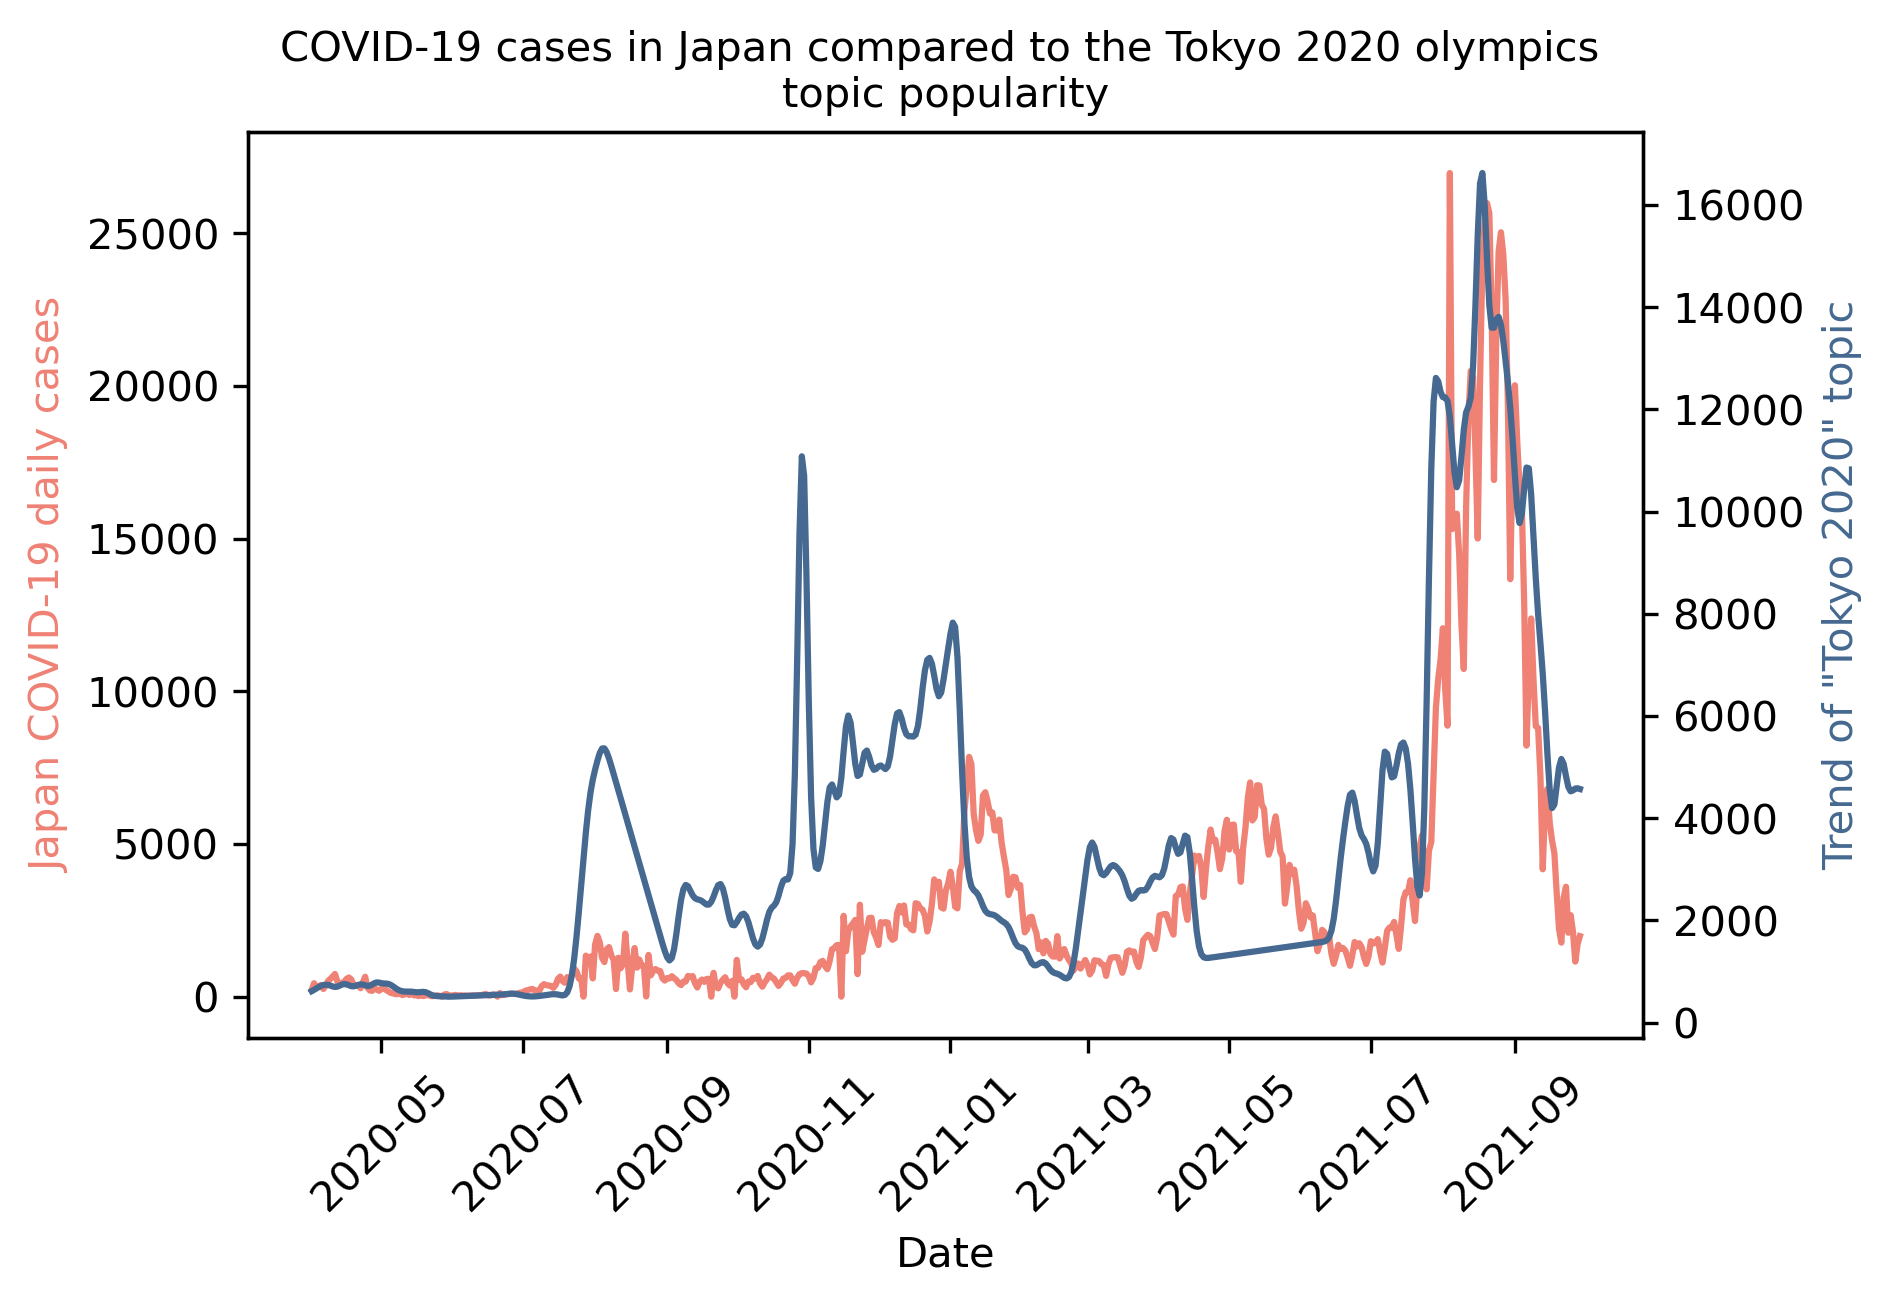

In [173]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(pd.date_range('2020-04-01', '2021-09-29'), japan_data['new_cases'], color="#EF8275")
ax.xaxis.set_tick_params(rotation=45)
# set x-axis label
ax.set_xlabel("Date",fontsize=10)
# set y-axis label
ax.set_ylabel("Japan COVID-19 daily cases",color="#EF8275",fontsize=10)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(pd.date_range('2020-04-01', '2021-09-29'), olympics_trend,color="#456990")
ax2.set_ylabel("Trend of \"Tokyo 2020\" topic",color="#456990",fontsize=10);
plt.title("COVID-19 cases in Japan compared to the Tokyo 2020 olympics \ntopic popularity", fontsize = 10);